In [1]:
%load_ext tensorboard
from pathlib import Path
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

为了防止tf过多的占用GPU显存，利用`set_memory_growth`函数来设置tf按需动态的获取资源

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 数据准备

1. 下载数据

In [3]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

2. 获取数据路径

In [4]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

3. 获取类别集合

In [5]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

class_names = [name.strip().lower() for name in train_classes]
class_names[0:10]

['garden hose',
 'lighter',
 'penguin',
 'tractor',
 'sheep',
 'skateboard',
 'mountain',
 'mouse',
 'chandelier',
 'guitar']

4. 加载数据（需要转义）

In [6]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)
batch_size = 256
train_set = quickdraw_dataset(train_files[:10], shuffle_buffer_size=10000, batch_size=batch_size)
valid_set = quickdraw_dataset(eval_files[:5], batch_size=batch_size)
test_set = quickdraw_dataset(eval_files[5:], batch_size=batch_size)

5. 预览数据

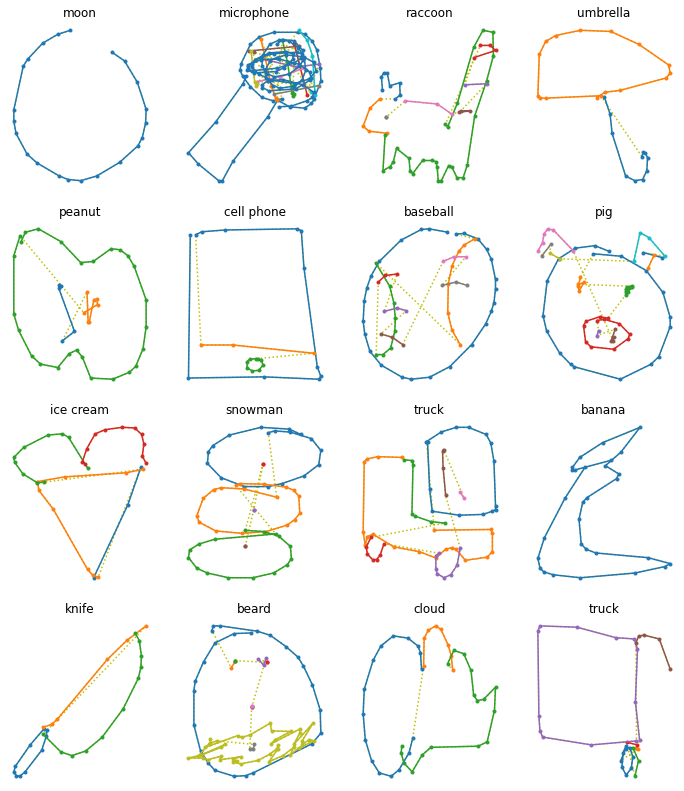

In [7]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches[:16], lengths[:16], labels[:16])

6. 统计数据长度

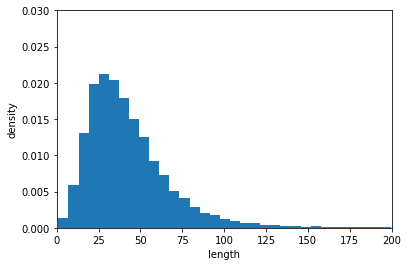

In [8]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(100)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

7. 选取100作为数据的标准长度，对数据进行剪裁

In [9]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)
del train_set, valid_set, test_set 

8. 创建RNN模型
   * LSTM
   * GRU
   * WaveNet

In [10]:
def LSTM():
    return keras.models.Sequential([
        keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(128),
        keras.layers.Dense(len(class_names), activation="softmax")
    ])

In [11]:
def GRU():
    return keras.models.Sequential([
        keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.GRU(128, return_sequences=True),
        keras.layers.GRU(128),
        keras.layers.Dense(len(class_names), activation="softmax")
    ])

In [12]:
def WaveNet(n_layers_per_block=10, n_blocks=3, n_filters=128, n_outputs=256):
    class GatedActivationUnit(keras.layers.Layer):
        def __init__(self, activation="tanh", **kwargs):
            super().__init__(**kwargs)
            self.activation = keras.activations.get(activation)
        def call(self, inputs):
            n_filters = inputs.shape[-1] // 2
            linear_output = self.activation(inputs[..., :n_filters])
            gate = keras.activations.sigmoid(inputs[..., n_filters:])
            return self.activation(linear_output) * gate

    def wavenet_residual_block(inputs, n_filters, dilation_rate):
        z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                                dilation_rate=dilation_rate)(inputs)
        z = GatedActivationUnit()(z)
        z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
        return keras.layers.Add()([z, inputs]), z


    inputs = keras.layers.Input(shape=[None, 3])
    z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
    skip_to_last = []
    for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
        z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
        skip_to_last.append(skip)
    z = keras.activations.relu(keras.layers.Add()(skip_to_last))
    z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
    Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

    model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])
    return model

9. 在GPU环境下编译模型

In [13]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu().

    Defined in :numref:`sec_use_gpu`"""
    if len(tf.config.experimental.list_physical_devices('GPU')) >= i + 1:
        return tf.device(f'/GPU:{i}')
    return tf.device('/CPU:0')

In [14]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

device = try_gpu()
device_name = device._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
with strategy.scope():
    optimizer = keras.optimizers.SGD(learning_rate=0.2, clipnorm=1.)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # model = GRU()
    model = GRU()
    model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

10. 模型训练

In [15]:
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                histogram_freq = 1,
                                                profile_batch = '500,520')
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set,
              callbacks = [tboard_callback])

Epoch 1/2
13477/13477 [==============================] - 387s 28ms/step - loss: 3.1276 - accuracy: 0.3213 - sparse_top_k_categorical_accuracy: 0.5727 - val_loss: 2.2078 - val_accuracy: 0.4753 - val_sparse_top_k_categorical_accuracy: 0.7587
Epoch 2/2
13477/13477 [==============================] - 369s 27ms/step - loss: 1.9488 - accuracy: 0.5298 - sparse_top_k_categorical_accuracy: 0.8005 - val_loss: 1.9512 - val_accuracy: 0.5273 - val_sparse_top_k_categorical_accuracy: 0.7993


In [16]:
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 24908), started 3:36:34 ago. (Use '!kill 24908' to kill it.)